This notebook creates daily forcing files for the sea surface height (hourly frequency) at Neah Bay. This can be used to create "obs" or "hindcast" forcing files for nowcasts in the event of a automation system error.


Observations: NOAA

Tidal predictions: calculated with t_tide based on NOAA time series. Tidal predictions do not include the long period constituents (Sa,Ssa,etc).

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import netCDF4 as NC
import numpy as np
import arrow
from dateutil import tz
import datetime

from salishsea_tools import nc_tools
from nowcast.figures import figures, shared
import os
import csv



# Observations and tidal predictions

Begin by loading Neah Bay water level observations and tidal predictions.

http://tidesandcurrents.noaa.gov/waterlevels.html?id=9443090

In [3]:
def get_obs_tides(station, start_date, end_date):
    station_no = figures.SITES[station]['stn_no']
    obs = figures.get_NOAA_wlevels(station_no, start_date, end_date)
    tide = shared.get_tides(station, path='../tidal_predictions/')
    print(obs.time[0], obs.time[-1])
    return obs, tide

In [4]:
def plot_obs_tides(ax, date, obs, tide):
    ax.plot(obs.time, obs.wlev, 'o',label='obs')
    ax.plot(tide.time, tide.pred_all,'r',lw=2,label='tides')
    ax.legend(loc=0)
    ax.set_ylabel('Water level [m]')
    ax.axis([date, date +datetime.timedelta(days=1),-3,3,])



# Interpolate data to on the hour

In [5]:
def inter_hourly(date, obs, tide):
#create houly times
    t1 = date.replace(tzinfo=tz.tzutc())
    t2 = t1 + datetime.timedelta(days=1)
    hourlys = [t1 + datetime.timedelta(hours=hour) for hour in np.arange(0,(t2-t1).total_seconds()/3600)]
    print(hourlys[0], hourlys[-1])
    obs_interp = shared.interp_to_model_time(hourlys, obs.wlev, obs.time)
    obs_interp = np.array(obs_interp)
    tides_interp = shared.interp_to_model_time(hourlys, tide.pred_all, tide.time)
    tides_interp = np.array(tides_interp)
    anom = obs_interp-tides_interp
    return hourlys, obs_interp, tides_interp, anom

In [6]:
def plot_hourlys(ax, hourlys, obs_interp, tides_interp, anom):
    ax.plot(hourlys, obs_interp, 'o',label='obs')
    ax.plot(hourlys, tides_interp, 'r', lw=2,label='tides')
    ax.plot(hourlys, anom,'-k',label='anom')
    ax.legend(loc=0)
    ax.set_ylabel('Water level [m]')



(24, 1, 87)


NameError: name 'anom' is not defined

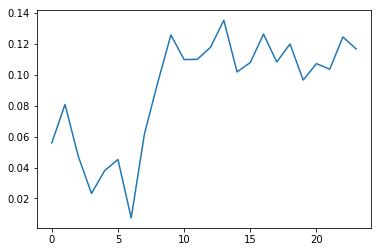

In [7]:
# Use this cell to test against a nowcast generated file
testfile = NC.Dataset('/results/forcing/sshNeahBay/obs/ssh_y2016m12d10.nc', 'r')
ssh = testfile.variables['sossheig'][:]
testfile.close()
print(ssh.shape)

plt.plot(ssh[:, 0, 5])
plt.plot(anom[:])
plt.plot(ssh[:, 0, 5] - anom[:])

# Save as a NetCDF

Follow Susan's SSH notebook for this. Make a new netcdf file for this day. I will save the anom at each point along the western boundary.

Get some preliminary data first: bathymetry, indices of the edges. 

In [10]:
startj = 384
endj = 471
lengthj = endj-startj
r = 1

fB = NC.Dataset('/results/nowcast-sys/NEMO-forcing/grid/bathymetry_201702.nc','r')
lat = fB.variables['nav_lat'][:]
lon = fB.variables['nav_lon'][:]
fB.close()
print(lat.shape)

(898, 398)


A function for saving the netcdf file.

In [11]:
def prepare_netcdf(ssh_file, count, ssh, date):
    
    filename = date.strftime('ssh_y%Ym%md%d.nc')
    # dataset attributes
    nc_tools.init_dataset_attrs(
    ssh_file, 
    title='Juan de Fuca SSH hourly values', 
    notebook_name='SSH_NeahBay', 
    nc_filepath='/results/forcing/sshNeahBay/hindcast/' + filename,
    comment='Neah Bay observed anomaly. Done in hindcast.')

    
    #dimensions
    ssh_file.createDimension('xbT', lengthj*r)
    ssh_file.createDimension('yb', 1)
    ssh_file.createDimension('time_counter', None)
    # variables
    # time_counter
    time_counter = ssh_file.createVariable('time_counter', 'float32', ('time_counter'))
    time_counter.long_name = 'Time axis'
    time_counter.axis = 'T'
    time_counter.units = 'hour since 00:00:00 on {}'.format(date.strftime('%d/%m/%Y'))
    # nav_lat and nav_lon
    nav_lat = ssh_file.createVariable('nav_lat','float32',('yb','xbT'))
    nav_lat.long_name = 'Latitude'
    nav_lat.units = 'degrees_north'
    nav_lon = ssh_file.createVariable('nav_lon','float32',('yb','xbT'))
    nav_lon.long_name = 'Longitude'
    nav_lon.units = 'degrees_east'
    # ssh
    sossheig = ssh_file.createVariable('sossheig', 'float32', 
                               ('time_counter','yb','xbT'), zlib=True)
    sossheig.units = 'm'
    sossheig.long_name = 'Sea surface height'   
    sossheig.coordinates = 'nav_lon nav_lat time_counter'
    sossheig.grid = 'SalishSea2'
    # vobtcrtx, vobtcrty
    vobtcrtx = ssh_file.createVariable('vobtcrtx', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrtx.units = 'm/s'
    vobtcrtx.long_name = 'Barotropic U Velocity- ZEROD'   
    vobtcrtx.grid = 'SalishSea2'
    vobtcrty = ssh_file.createVariable('vobtcrty', 'float32',
                                   ('time_counter','yb','xbT'), zlib=True)
    vobtcrty.units = 'm/s'
    vobtcrty.long_name = 'Barotropic V Velocity- ZEROD'   
    vobtcrty.grid = 'SalishSea2'
    # nbidta, ndjdta, ndrdta
    nbidta = ssh_file.createVariable('nbidta', 'int32' , ('yb','xbT'), zlib=True)
    nbidta.long_name = 'i grid position'
    nbidta.units = 1
    nbjdta = ssh_file.createVariable('nbjdta', 'int32' , ('yb','xbT'), zlib=True)
    nbjdta.long_name = 'j grid position'
    nbjdta.units = 1
    nbrdta = ssh_file.createVariable('nbrdta', 'int32' , ('yb','xbT'), zlib=True)
    nbrdta.long_name = 'position from boundary'
    nbrdta.units = 1
    
    for ir in range(0,r):
        nav_lat[0,ir*lengthj:(ir+1)*lengthj] = lat[startj:endj,ir]
        nav_lon[0,ir*lengthj:(ir+1)*lengthj] = lon[startj:endj,ir]
        nbidta[0,ir*lengthj:(ir+1)*lengthj] = ir
        nbjdta[0,ir*lengthj:(ir+1)*lengthj] = range(startj,endj)
        nbrdta[0,ir*lengthj:(ir+1)*lengthj] = ir
        
    for ib in range(0,lengthj*r):
        sossheig[0:count,0,ib] = ssh[0:count]
        time_counter[0:count] = range(1,count+1)
        vobtcrtx[0:count,0,ib] = 0*np.ones(count)
        vobtcrty[0:count,0,ib] = 0*np.ones(count)


## Driver Cell ##

01-Jan-2015 31-Mar-2015
2015-01-01 00:00:00+00:00 2015-01-01 23:54:00+00:00
2015-01-01 00:00:00+00:00 2015-01-01 23:00:00+00:00
file format: NETCDF4
Conventions: CF-1.6
title: Juan de Fuca SSH hourly values
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/salishseanowcast/src/tip/SSH_NeahBay.ipynb
references: REQUIRED
history: [2017-05-02 16:18:19] Created netCDF4 zlib=True dataset.
comment: Neah Bay observed anomaly. Done in hindcast.
2015-01-02 00:00:00+00:00 2015-01-02 23:54:00+00:00
2015-01-02 00:00:00+00:00 2015-01-02 23:00:00+00:00
file format: NETCDF4
Conventions: CF-1.6
title: Juan de Fuca SSH hourly values
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/salishseanowcast/src/tip/SSH_NeahBay.ipynb
references: REQUIRED
history: [2017-05-02 16:18:26] Created netCDF4 zlib=True dataset.
comment: Neah Bay observed anomaly. Do

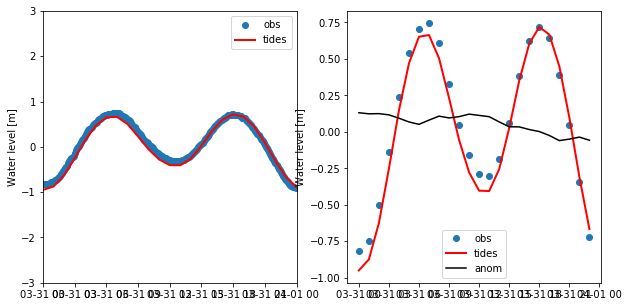

In [13]:
station = 'Neah Bay'; nhours = 24
start_date = arrow.get(2015, 1, 1)
end_date = arrow.get(2015, 3, 31)
print (start_date.format('DD-MMM-YYYY'), end_date.format('DD-MMM-YYYY'))

for day in arrow.Arrow.range('day', start_date, end_date):
    date = day.format('DD-MMM-YYYY')
    obs, tide = get_obs_tides(station, date, date)
    hourlys, obs_interp, tides_interp, anom = inter_hourly(day.datetime, obs, tide)
    filename = day.datetime.strftime('ssh_y%Ym%md%d.nc')
    ssh_file = NC.Dataset(filename, 'w', zlib=True)
    prepare_netcdf(ssh_file, nhours, anom, day.datetime)
    ssh_file.close()

fig, axs = plt.subplots(1,2, figsize=(10, 5))
plot_obs_tides(axs[0], day.datetime, obs, tide)
plot_hourlys(axs[1], hourlys, obs_interp, tides_interp, anom)


Check the NetCDF files

A quick check that the data is saved in the netcdf file as expected. 

<class 'netCDF4._netCDF4.Dimension'>: name = 'xbT', size = 87

<class 'netCDF4._netCDF4.Dimension'>: name = 'yb', size = 1

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 24

(24, 1, 87)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
-0.06038
0.13071
(24, 1, 87)


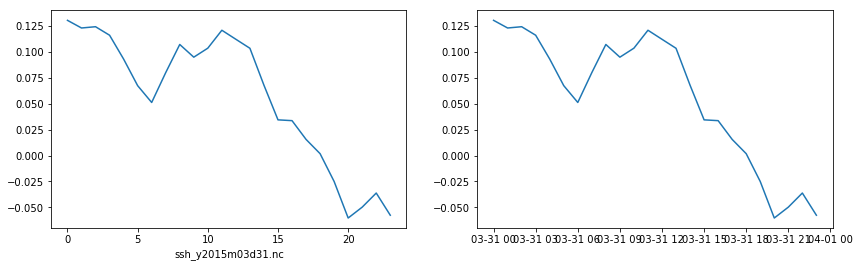

In [14]:


f=  NC.Dataset(filename,'r');

for dim in f.dimensions.values():
    print (dim)
    
ssh=f.variables['sossheig'];
us=f.variables['vobtcrtx'];
vs=f.variables['vobtcrty'];
print( us.shape)
print (us[1,0,:])
print (vs[:,0,:])
    
mn = ssh[:].min(); print (mn)
mx = ssh[:].max(); print (mx)

fig, ((ax_net,ax_data)) = plt.subplots(1, 2, figsize=(14,4))
ax_net.plot(ssh[:,0,0])
ax_net.set_xlabel(filename)

ax_data.plot(hourlys,anom)

print(ssh.shape)

This looks good so let's move the files out of my working directory and into the forcing directory. 

In [15]:
srcdir='.'
dstdir='/results/forcing/sshNeahBay/hindcast/'

import shutil

for basename in os.listdir(srcdir):
    if basename.endswith('.nc'):
        pathname = os.path.join(srcdir, basename)
        if os.path.isfile(pathname):
            shutil.copy2(pathname, dstdir)


You can delete the copy in your working directory now.